In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_ZN
working_dir = fs.WORKING_DIR_ZN
fs.setup_pest_zn()

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_zn
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_zones/freyberg_zn/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGIC

/Users/jwhite/Dev/python/pyemu/pyemu/pst/pst_utils.py:419: UserWarning: pst_from_io_files has moved to pyemu.helpers and is also now avaiable as a Pst class method (Pst.from_io_files())
  "now avaiable as a Pst class method (Pst.from_io_files())")


run():./inschek freyberg.travel.ins freyberg.travel
run():./inschek vol.dat.ins vol.dat
run():./pestchek freyberg_zn.pst
run():./pestpp freyberg_zn.init.pst


run pestpp

In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 10
pst.write(os.path.join(working_dir,pst_name))
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():pestpp freyberg_zn.pst


In [4]:
pst.phi

444.1518418256817

In [5]:
pst.phi_components

{'calflux': 0.02248834135425831,
 'calhead': 444.12935348432745,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [6]:
pst.res.loc[pst.nnz_obs_names,:]

,name,group,measured,modelled,residual,weight
name,,,,,,
flx_river_l_19700102,flx_river_l_19700102,calflux,-3706.027000,-3707.526611,1.499611,0.1
cr03c16_19700102,cr03c16_19700102,calhead,18.864677,19.687841,-0.823164,5.0
cr03c10_19700102,cr03c10_19700102,calhead,20.920237,21.744995,-0.824758,5.0
cr04c9_19700102,cr04c9_19700102,calhead,23.287189,22.130009,1.157180,5.0
cr10c2_19700102,cr10c2_19700102,calhead,28.141190,28.183842,-0.042652,5.0
cr14c11_19700102,cr14c11_19700102,calhead,20.524639,18.069366,2.455272,5.0
cr16c17_19700102,cr16c17_19700102,calhead,15.522017,17.246733,-1.724716,5.0
cr22c11_19700102,cr22c11_19700102,calhead,19.704904,19.174065,0.530840,5.0
cr23c16_19700102,cr23c16_19700102,calhead,15.644862,16.533676,-0.888814,5.0


(11.957479976379247, 28.91906945362075)

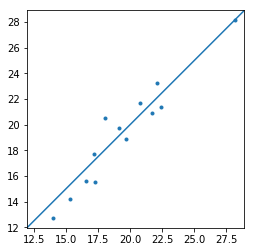

In [11]:
ax = plt.subplot(111,aspect="equal") 
wl_names = [n for n in pst.nnz_obs_names if n.startswith("c")]
ax.scatter(pst.res.loc[wl_names,"modelled"],pst.res.loc[wl_names,"measured"],marker='.')
ylim,xlim = ax.get_ylim(),ax.get_xlim()
mn = min(ylim[0],xlim[0])
mx = max(ylim[1],xlim[1])
ax.plot([mn,mx],[mn,mx])
ax.set_ylim(mn,mx)
ax.set_xlim(mn,mx)

In [12]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
RCH_0,0.00000,0.055462,-0.110924,0.110924,0.017462,0.010637,-0.003812,0.038737
RCH_1,0.00000,0.055462,-0.110924,0.110924,0.000000,0.055462,-0.110924,0.110924
HK_Z01,0.69897,0.500000,-0.301030,1.698970,1.525990,0.499986,0.526023,2.525970
HK_Z02,0.69897,0.500000,-0.301030,1.698970,0.841201,0.390475,0.060251,1.622150
HK_Z03,0.69897,0.500000,-0.301030,1.698970,1.044620,0.228357,0.587904,1.501330
HK_Z04,0.69897,0.500000,-0.301030,1.698970,1.058560,0.335238,0.388087,1.729040
HK_Z05,0.69897,0.500000,-0.301030,1.698970,-0.061941,0.289097,-0.640135,0.516253
HK_Z06,0.69897,0.500000,-0.301030,1.698970,1.368220,0.225224,0.917776,1.818670


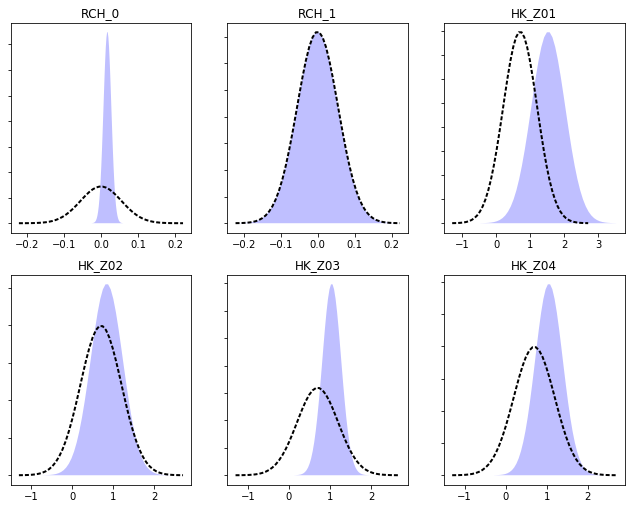

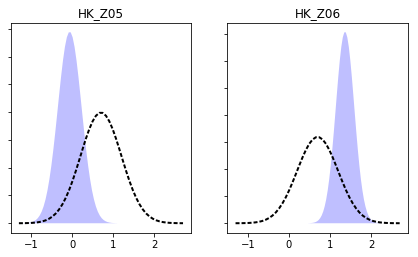

In [13]:
axes = pyemu.helpers.plot_summary_distributions(df_paru,subplots=True)

In [14]:
df_predu = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)

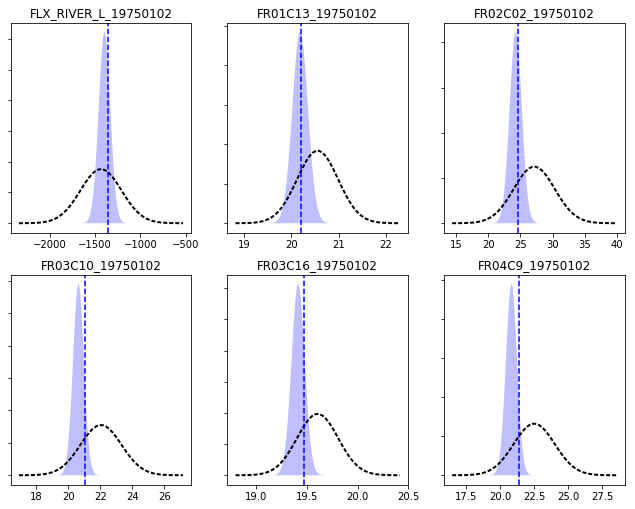

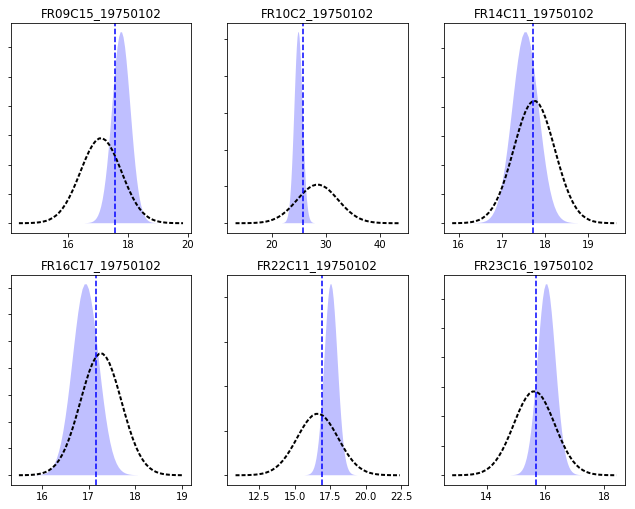

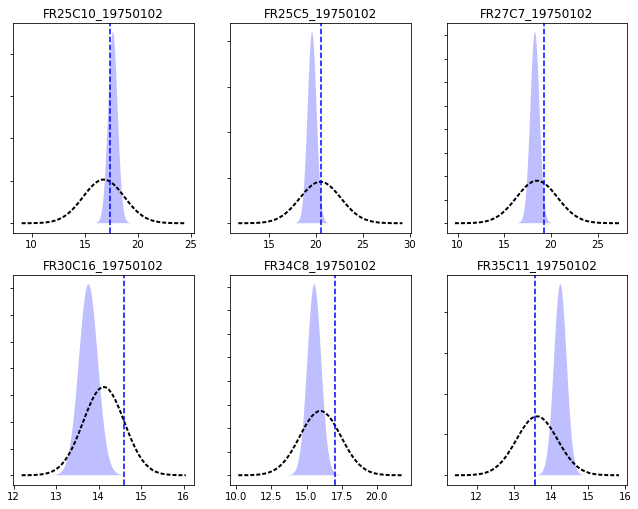

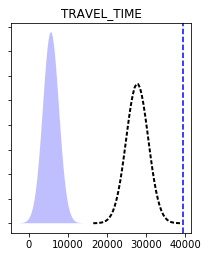

In [16]:
figs, axes = pyemu.helpers.plot_summary_distributions(df_predu,subplots=True)
for ax in axes:
    fname = ax.get_title().lower()
    ylim = ax.get_ylim()
    v = pst.observation_data.loc[fname,"obsval"]
    ax.plot([v,v],ylim,"b--")
    ax.set_ylim(ylim)

Now we have some variability in the forecast outcomes...why?

As far as the "truth" is concerned, we are doing better for most forecasts.  But we are especially bad for the tranvel time forecast - why?  What affects travel time?